## FuseNet - Loss, Accuracy, Test

<img src="http://vision.in.tum.de/_media/spezial/bib/hazirbasma2016fusenet.png">
<br>
<td> <b>Training Information & Test Results: </b> 
  <div class="popup">
    <br> FuseNet on NYU v2 - 220 Epochs
    <br> Training period: 02.07.2017 14:00 - 19:40 ~ 5.5 hrs 
    <br> Best global pixel-wise accuracy: <b>0.668</b> mean class-wise IoU accuracy: 0.300 mean accuracy: <b>0.444</b>
    <br> Org. global pixel-wise accuracy: 0.660 mean class-wise IoU accuracy: <b>0.327</b> mean accuracy: 0.434
    <br> Learning rate: 0.01 lr decay: 0.9 per 40 epochs weight decay: 0.0005 batch size: 4 best validation accuracy on epoch: 216
    <br>
    <br> FuseNet on SUN RGB-D - 250 Epochs
    <br> Training period: 02.07.2017 20:00 - 03.07.2017 17:00 ~ 21 hrs 
    <br> Best global pixel-wise accuracy: <b>0.777</b> mean class-wise IoU accuracy: 0.273 mean accuracy: 0.479
    <br> Org. global pixel-wise accuracy: 0.763 mean class-wise IoU accuracy: <b>0.373</b> mean accuracy: <b>0.483</b>
    <br> learning rate: 0.01 lr decay: 0.9 per 40 epochs weight decay: 0.0005 batch size: 4 best validation accuracy on epoch: 250
    <br> 
    <br>
  </div>
</td>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import h5py
import scipy.io
import os

from FuseNet import FuseNet
from utils.data_utils import get_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2


## Plot the loss, training and validation accuracy 

- During training, the training accuracy was saved for the last batch at the end of each epoch. That's why the training accuracy plot looks mad.

PLOT SELECTION. Enter '1' for NYU '2' for SUN RGB-D
1
[PROGRESS] Loading checkpoint: '/usr/stud/soenmeza/Desktop/FuseNet/models/nyu/checkpoint25.pth.tar'


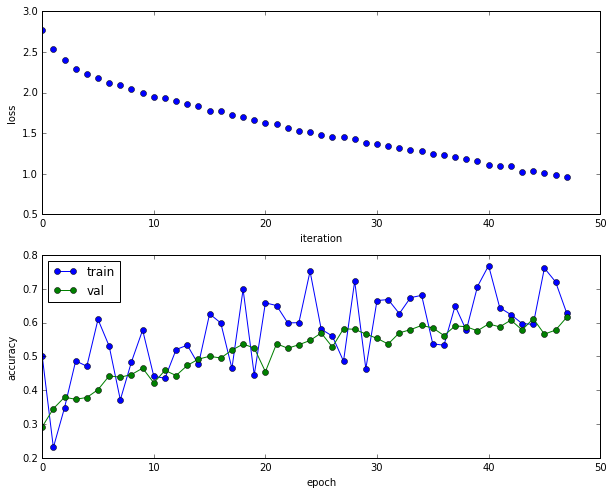

Minimum loss achieved: 0.961
Max validation accuracy until epoch number 250: 0.615
Best global pixel-wise accuracy: 0.615 achieved on epoch: 47


In [4]:
print("PLOT SELECTION. Enter '1' for NYU '2' for SUN RGB-D")

while True:
    data = input()
    if data == 1:
        #model_path = '/work/soenmeza/FuseNet/models/nyu/checkpoint19.pth.tar'
        model_path = '/usr/stud/soenmeza/Desktop/FuseNet/models/nyu/checkpoint25.pth.tar'
        break
    elif data == 2:
        #model_path = '/work/soenmeza/FuseNet/models/sun/checkpoint7.pth.tar'
        model_path = '/work/soenmeza/FuseNet/models/sun/model_best17.pth.tar'    
        break
    else:
        print("You gave a wrong input!")
        continue
        
if os.path.isfile(model_path):
    print("[PROGRESS] Loading checkpoint: '{}'".format(model_path))
    checkpoint = torch.load(model_path)
    trained_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    train_loss_history = checkpoint['train_loss_hist']
    train_acc_history = checkpoint['train_acc_hist']
    val_acc_history = checkpoint['val_acc_hist']
else:   
    print("[ERROR] No checkpoint found at '{}'".format(model_path))  

plt.subplot(2, 1, 1)
plt.plot(train_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

epoch = 250
print("Minimum loss achieved: %.3f" %(np.min(train_loss_history)))
print("Max validation accuracy until epoch number %i: %.3f" %(epoch, np.max(val_acc_history[0:epoch])) )
print("Best global pixel-wise accuracy: %.3f achieved on epoch: %i" %(np.max(val_acc_history), np.argmax(val_acc_history)))

## Get train and validation data

In [5]:
print("Dataset Selection. Please enter '1' to load NYU dataset and '2' to load SUN RGB-D dataset: ")

while True:
    data = input()
    if data == 1:
        dset_type = 'NYU'
        #model_path = '/rework/soenmeza/FuseNet/models/nyu/model_best10.pth.tar'
        num_classes = 40
        break
    elif data == 2:
        dset_type = 'SUN'
        #model_path = '/work/soenmeza/FuseNet/models/sun/checkpoint7.pth.tar'
        #model_path = '/rework/soenmeza/FuseNet/models/sun/model_best11.pth.tar'    
        num_classes = 37
        break
    else:
        print("You gave a wrong input!")
        continue

train_data, val_data = get_data(dset_type=dset_type)

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=1)

print ("[PROGRESS] %s dataset retrieved"  %(dset_type))

model = FuseNet(num_classes)

print("[PROGRESS] Model created")

Dataset Selection. Please enter '1' to load NYU dataset and '2' to load SUN RGB-D dataset: 
1
[PROGRESS] NYU dataset retrieved
[PROGRESS] Model created


## Test the model

In [9]:
gpu_device = 0
torch.cuda.set_device(gpu_device)
print('[PROGRESS] Chosen GPU Device: ' + str(torch.cuda.current_device()))

if dset_type == 'NYU':
    model_path = '/usr/stud/soenmeza/Desktop/FuseNet/models/nyu/model_best19.pth.tar'
elif dset_type == 'SUN':
    model_path = '/work/soenmeza/FuseNet/models/sun/model_best17.pth.tar'

if os.path.isfile(model_path):
    print("[PROGRESS] Loading checkpoint: '{}'".format(model_path))
    checkpoint = torch.load(model_path)
    best_model = model
    trained_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_model.load_state_dict(checkpoint['best_state_dict'])
    best_model.eval()
    val_acc_history = checkpoint['val_acc_hist']
else:   
    print("[ERROR] No checkpoint found at '{}'".format(model_path))  

# Calculate IoU and Mean accuracies
val_confusion = np.zeros((num_classes,3))
val_scores = []
length = []
IoU = 0.0
mean_acc = 0.0
global_acc = 0.0
total = 0.0

for batch in val_loader:
    val_rgb_inputs  = Variable(batch[0].cuda(gpu_device))
    val_d_inputs    = Variable(batch[1].cuda(gpu_device))
    val_labels      = Variable(batch[2].cuda(gpu_device))
    val_outputs     = best_model(val_rgb_inputs, val_d_inputs)
    _, val_preds    = torch.max(val_outputs, 1)

    val_labels = val_labels - 1
    
    labels_mask = val_labels >= 0
    length.append(np.shape((val_preds == val_labels)[labels_mask].data.cpu().numpy()))
    val_scores.append(np.sum((val_preds == val_labels)[labels_mask].data.cpu().numpy()))
    
    for i in range(num_classes):
        val_labels_mask = val_labels == i
        val_preds_mask = val_preds == i
        TP = np.sum((val_preds == val_labels)[val_labels_mask].data.cpu().numpy())
        val_confusion[i,0] += TP
        val_confusion[i,1] += np.sum((val_labels==val_labels)[val_labels_mask].data.cpu().numpy()) - TP
        val_confusion[i,2] += np.sum((val_preds==val_preds)[val_preds_mask].data.cpu().numpy()) - TP

val_acc = np.sum(val_scores)
len_sum = np.sum(length)
val_acc /= len_sum
        
for i in range(num_classes):
    TP, FP, FN = val_confusion[i]
    total += TP + FP 
    global_acc += TP
    IoU += TP / (TP + FP + FN)
    mean_acc += TP / (TP + FP)
IoU /= num_classes
mean_acc /= num_classes
global_acc /= total

print("[FINAL] TEST COMPLETED")
print("        Best VALIDATION Accuracy: %.3f IoU: %.3f Mean Accuracy: %.3f" % (global_acc, IoU, mean_acc))

if dset_type == 'NYU':
    print("        Orgnal. FuseNet Accuracy: 0.660 IoU: 0.327 Mean Accuracy: 0.434")
else:
    print("        Orgnal. FuseNet Accuracy: 0.763  IoU: 0.373 Mean Accuracy: 0.483")

[PROGRESS] Chosen GPU Device: 0
[PROGRESS] Loading checkpoint: '/usr/stud/soenmeza/Desktop/FuseNet/models/nyu/model_best19.pth.tar'
[FINAL] TEST COMPLETED
        Best VALIDATION Accuracy: 0.618 IoU: 0.220 Mean Accuracy: 0.338
        Orgnal. FuseNet Accuracy: 0.660 IoU: 0.327 Mean Accuracy: 0.434
